# Lab 5. Efficiency, parallel Processing and benchmarking
#### Computational Methods for Geoscience
#### Instructor: Eric Lindsey

Due: Oct. 17, 2023

---------

In this lab, we'll use some tricks to speed up processing of a big dataset that would take too much time to run in a simple way.

In [1]:
# some useful imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interactive
import netCDF4 as nc
import datetime
import scipy.optimize
import time
import multiprocessing as mp
%config InlineBackend.figure_format = 'retina' # better looking figures on high-resolution screens

# automatically reload modules when running, otherwise jupyter does not notice if our functions have changed
%load_ext autoreload
%autoreload 2


## Assignment 1: 

a. Write a short function that accepts an integer N, and generates synthetic noisy data (x and y values) that roughly follow a linear relationship. 

b. Run your line-fitting function (from last week's lab) on these synthetic data several times, varying the value of N in a few steps between 10 to 1,000,000 points.

c. Plot the run time of the line-fitting operation against the number of data points on a log-log plot. What is the scaling relationship?

[0.0022046000231057405, 0.0019613999756984413, 0.002947599976323545, 0.005231199960689992, 0.004699299985077232, 0.005726700008381158, 0.0064836000092327595, 0.007255800010170788, 0.010706199973355979, 0.01080539997201413, 0.010366400005295873, 0.022766700014472008, 0.024109499994665384, 0.026514299970585853, 0.02561100001912564, 0.029136600031051785, 0.027525999990757555, 0.03171099995961413, 0.03478779998840764, 0.05213289998937398, 0.03659079998033121, 0.032880600017961115, 0.034338299999944866, 0.03629040002124384, 0.03668320004362613, 0.03480480000143871, 0.03872469998896122, 0.04413709999062121, 0.045244299981277436, 0.046900799963623285, 0.051046399981714785, 0.05118169996421784, 0.04860560002271086, 0.048825400008354336, 0.05527740000979975, 0.053593500051647425, 0.05740470002638176, 0.05532859999220818, 0.06335860001854599, 0.054243699996732175, 0.05916669999714941, 0.058104600000660866, 0.05485919996863231, 0.06883279996691272, 0.07401039998512715, 0.06696790002752095, 0.0680

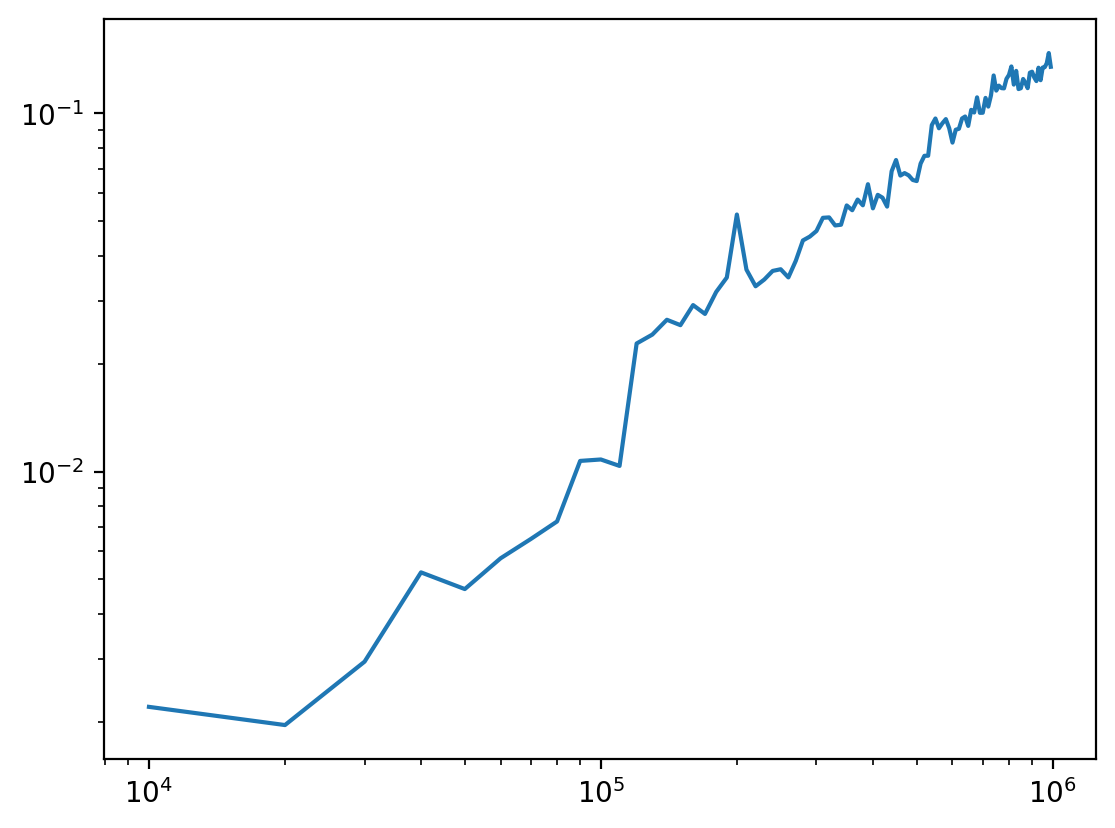

In [26]:
def gen_noisy_data(N, noise_level):
    slope = 3
    x = np.arange(0, N, 1)
    y_clean = x * slope
    noise = np.random.normal(0, noise_level, N)
    y = y_clean + noise
    
    return x, y

def fit_line(xdata, ydata):
    def linear_func(x, a, b):
        return a*x + b
    
    fit, uncertainty = scipy.optimize.curve_fit(f = linear_func,
                                                  xdata = xdata,
                                                  ydata = ydata)
    y_fit = xdata * fit[0]
    
    return y_fit

N_steps = np.arange(10000, 1000000, 10000)

time_list = []

for N in N_steps:
    init_time = time.perf_counter()
    x, y = gen_noisy_data(N, 10)
    y_fit = fit_line(x, y)
    end_time = time.perf_counter()
    run_time = end_time - init_time
    time_list.append(run_time)
    
print(time_list)

plt.loglog(N_steps, time_list)

## Assignment 2: Sea surface temperature trends

We have been working with the SST data for a few weeks now. You previously downloaded the large file 'sst.mon.mean.nc', which includes maps of measured and estimated sea surface temperatures every month, over the past 130 years. Considering the effects of climate change on the oceans, do you think the sea surface has gotten warmer over time?

a. Use your line-fitting function from above to fit a line to the SST trend at one point, using decimal years as your t-axis. Make a plot showing the data and the linear fit at that point. (This is very similar to an assignment we did already! Feel free to reuse your code).

b. Try running the line-fitting function over all points on earth. Store the resulting slope value (in units of degrees C per year) in a new matrix with the same size as the original map (180 rows, 360 columns). There are 64800 timeseries to be fit, so this could take a long time. Some things to consider:

* The continents are invalid data. We should be able to skip over those and just return `np.nan` for the slope immediately.
* The NetCDF format of the data is slow to use. Try converting your data to a np.array() first to speed things up.
* Think carefully about how you are accessing and storing your data to speed things up a bit more.
* Try running things in parallel if you want, to get even more speedup!

c. Make a map showing the rate of SST change at every point in the oceans.

d. Report how long it takes in total to fit a line to every timeseries in the dataset. Fastest time wins!


Happy coding! Feel free to work in groups, or get in touch with me if you get stuck.